In [1]:
# 导入
import pandas as pd

In [2]:
# 读取数据
balance = pd.read_csv('../purchase_redeem/user_balance_table.csv')
balance.head()

,user_id,report_date,tBalance,yBalance,total_purchase_amt,direct_purchase_amt,purchase_bal_amt,purchase_bank_amt,total_redeem_amt,consume_amt,transfer_amt,tftobal_amt,tftocard_amt,share_amt,category1,category2,category3,category4
0,1,20140805,20385,20383,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
1,1,20140808,20391,20389,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
2,1,20140811,20397,20395,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
3,1,20140814,20403,20401,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN
4,1,20140817,20409,20407,2,0,0,0,0,0,0,0,0,2,NaN,NaN,NaN,NaN


In [3]:
# 取其中有用的几列，时间，申购，赎回
purchase_redeem = balance[['report_date','total_purchase_amt','total_redeem_amt']].sort_values(by='report_date').reset_index(drop=True)
purchase_redeem

,report_date,total_purchase_amt,total_redeem_amt
0,20130701,0,0
1,20130701,2,0
2,20130701,0,0
3,20130701,37,0
4,20130701,10131,0
...,...,...,...
2840416,20140831,11,0
2840417,20140831,383,0
2840418,20140831,499,0
2840419,20140831,0,0


In [4]:
# 将时间格式转换
purchase_redeem['report_date'] = pd.to_datetime(purchase_redeem['report_date'], format='%Y%m%d')

In [9]:
# 以每一天聚合申购，赎回量
purchase_redeem = purchase_redeem.groupby('report_date',as_index=False).sum()
purchase_redeem.head()

,report_date,total_purchase_amt,total_redeem_amt
0,2013-07-01,32488348,5525022
1,2013-07-02,29037390,2554548
2,2013-07-03,27270770,5953867
3,2013-07-04,18321185,6410729
4,2013-07-05,11648749,2763587


In [10]:
# 只取3月1日以后的数据
purchase_redeem = purchase_redeem[purchase_redeem['report_date'] >= '2014-03-01'].reset_index(drop=True)
purchase_redeem.head()

,report_date,total_purchase_amt,total_redeem_amt
0,2014-03-01,362865580,211279011
1,2014-03-02,276202230,246199417
2,2014-03-03,505305862,513017360
3,2014-03-04,524146340,250562978
4,2014-03-05,454295491,209072753


In [11]:
purchase_redeem.shape

(184, 3)

### 步骤：
* 1.计算周期因子factor
* 2.计算base，再计算pure base
* 3.利用pure base乘上 factor，得到预测结果

#### 1. 计算周期因子
* 统计周一。。。周日的均值，除以所有值的均值

In [12]:
# 加入weekday
purchase_redeem['weekday'] = purchase_redeem['report_date'].dt.weekday
purchase_redeem.head()

,report_date,total_purchase_amt,total_redeem_amt,weekday
0,2014-03-01,362865580,211279011,5
1,2014-03-02,276202230,246199417,6
2,2014-03-03,505305862,513017360,0
3,2014-03-04,524146340,250562978,1
4,2014-03-05,454295491,209072753,2


In [13]:
# 查看weekday的取值情况，0为星期一。。。。
purchase_redeem.weekday.value_counts()

6    27
5    27
4    26
3    26
2    26
1    26
0    26
Name: weekday, dtype: int64

### 这里有问题！！！应该先聚合每一天，然后再根据weekday来进行平均，因为每一天有不一样的数据，我们要计算的是这一天(1号，2号。。。)的总量，在平均？

In [14]:
# 计算每个weekday的均值
factor = purchase_redeem.groupby('weekday', as_index=False)['total_purchase_amt', 'total_redeem_amt'].mean()
factor

e:\tool\python36\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,weekday,total_purchase_amt,total_redeem_amt
0,0,3.273693e+08,3.456808e+08
1,1,3.340518e+08,3.221266e+08
2,2,3.213877e+08,3.181960e+08
3,3,3.146910e+08,2.821480e+08
4,4,2.492893e+08,2.680463e+08
5,5,1.958666e+08,1.840544e+08
6,6,1.966477e+08,2.093138e+08


In [15]:
# 求均值，得到周期因子
factor['total_purchase_amt'] = factor['total_purchase_amt']/factor['total_purchase_amt'].mean()
factor['total_redeem_amt'] = factor['total_redeem_amt']/factor['total_redeem_amt'].mean()

factor.rename(columns = {'total_purchase_amt':'purchase_factor', 'total_redeem_amt':'redeem_factor'}, inplace=True)

factor

,weekday,purchase_factor,redeem_factor
0,0,1.181654,1.254047
1,1,1.205775,1.168598
2,2,1.160063,1.154339
3,3,1.135891,1.023565
4,4,0.899820,0.972407
5,5,0.706989,0.667705
6,6,0.709808,0.759340


### 2.Base
* 计算每一号(1-31号)的Base，再通过历史该号的星期的周期因子，去除周期性，得到pure base

In [16]:
purchase_redeem['day'] = purchase_redeem['report_date'].dt.day
purchase_redeem

,report_date,total_purchase_amt,total_redeem_amt,weekday,day
0,2014-03-01,362865580,211279011,5,1
1,2014-03-02,276202230,246199417,6,2
2,2014-03-03,505305862,513017360,0,3
3,2014-03-04,524146340,250562978,1,4
4,2014-03-05,454295491,209072753,2,5
...,...,...,...,...,...
179,2014-08-27,302194801,468164147,2,27
180,2014-08-28,245082751,297893861,3,28
181,2014-08-29,267554713,273756380,4,29
182,2014-08-30,199708772,196374134,5,30


In [17]:
# 计算base, 1,2...31号的均值！
base = purchase_redeem.groupby('day',as_index=False)[['total_purchase_amt', 'total_redeem_amt']].sum()
base['count'] = purchase_redeem.day.value_counts().sort_index().values
base['total_purchase_amt'] = base['total_purchase_amt']/base['count']
base['total_redeem_amt'] = base['total_redeem_amt']/base['count']
base.rename(columns={'total_purchase_amt':'purchase_base', 'total_redeem_amt':'redeem_base'})

,day,purchase_base,redeem_base,count
0,1,3.253391e+08,2.347676e+08,6
1,2,2.481255e+08,2.186074e+08,6
2,3,2.994808e+08,2.968247e+08,6
3,4,3.159802e+08,2.925598e+08,6
4,5,3.286272e+08,2.552484e+08,6
5,6,2.998453e+08,2.460958e+08,6
6,7,2.836725e+08,2.374837e+08,6
7,8,2.918664e+08,2.475255e+08,6
8,9,2.856603e+08,2.440269e+08,6
9,10,3.446347e+08,2.593854e+08,6


In [18]:
# 但这个均值是来自不同星期的，每个星期又有不同的周期因子(这里的星期是指，星期一星期二星期。。。)
# 例如day=1，指的是每个月的一号，而这个一号的平均来自于历史几个月的一号，而历史几个月中的一号可能来自星期一、星期三等。。。
# 假如历史6-9中，6.1是星期一，7.1是星期四，8.1是星期三，则这个三个月的平均base中，蕴含了周期性，因此需要将其去掉
# 周一因子为1.1，周三1.6，周四1.2，则（1.1+1.2+1.6）/3=average_factor4one。接着用base/average_factor4one得到pure base

In [19]:
temp = purchase_redeem.copy()
p_r = temp.copy()

In [20]:
p_r = p_r[['report_date','weekday','day']]
p_r = p_r.merge(factor, on='weekday')
p_r

,report_date,weekday,day,purchase_factor,redeem_factor
0,2014-03-01,5,1,0.706989,0.667705
1,2014-03-08,5,8,0.706989,0.667705
2,2014-03-15,5,15,0.706989,0.667705
3,2014-03-22,5,22,0.706989,0.667705
4,2014-03-29,5,29,0.706989,0.667705
...,...,...,...,...,...
179,2014-08-01,4,1,0.899820,0.972407
180,2014-08-08,4,8,0.899820,0.972407
181,2014-08-15,4,15,0.899820,0.972407
182,2014-08-22,4,22,0.899820,0.972407


In [21]:
# 按day weekday 分，然后拼接weekday factor
average_factor = p_r.groupby(['day', 'weekday'],as_index=False)['report_date'].count()
average_factor.rename(columns = {'report_date':'count'}, inplace=True)
average_factor

,day,weekday,count
0,1,1,2
1,1,3,1
2,1,4,1
3,1,5,1
4,1,6,1
...,...,...,...
149,30,6,1
150,31,0,1
151,31,3,1
152,31,5,1


In [22]:
#### 这一号，在星期几(weekday)出现了几次（count），再除以这一号有几次
average_factor = average_factor.merge(factor, on='weekday')

average_factor['purchase_factor'] = average_factor['purchase_factor'] * average_factor['count']
average_factor['redeem_factor'] = average_factor['redeem_factor'] * average_factor['count']
average_factor

,day,weekday,count,purchase_factor,redeem_factor
0,1,1,2,2.411549,2.337195
1,3,1,1,1.205775,1.168598
2,4,1,1,1.205775,1.168598
3,5,1,1,1.205775,1.168598
4,6,1,1,1.205775,1.168598
...,...,...,...,...,...
149,25,2,1,1.160063,1.154339
150,26,2,1,1.160063,1.154339
151,27,2,1,1.160063,1.154339
152,28,2,1,1.160063,1.154339


In [23]:
temp1 = average_factor.groupby('day', as_index=False).sum()[['day','count','purchase_factor','redeem_factor']]
temp1

,day,count,purchase_factor,redeem_factor
0,1,6,5.864058,5.760212
1,2,6,5.818398,5.962176
2,3,6,6.076007,5.896819
3,4,6,6.056940,6.281138
4,5,6,6.097360,5.935958
5,6,6,5.821166,5.837588
6,7,6,6.266071,6.326109
7,8,6,5.864058,5.760212
8,9,6,5.818398,5.962176
9,10,6,6.076007,5.896819


In [24]:
temp1['purchase_factor'] = temp1['purchase_factor']/temp1['count']
temp1['redeem_factor'] = temp1['redeem_factor']/temp1['count']
temp1

,day,count,purchase_factor,redeem_factor
0,1,6,0.977343,0.960035
1,2,6,0.969733,0.993696
2,3,6,1.012668,0.982803
3,4,6,1.009490,1.046856
4,5,6,1.016227,0.989326
5,6,6,0.970194,0.972931
6,7,6,1.044345,1.054352
7,8,6,0.977343,0.960035
8,9,6,0.969733,0.993696
9,10,6,1.012668,0.982803


In [25]:
average_factor = temp1[['day', 'purchase_factor', 'redeem_factor']]

### 拼接

In [26]:
pure_base = base.merge(average_factor, on='day')

In [27]:
pure_base['total_purchase_amt'] = pure_base['total_purchase_amt'] / pure_base['purchase_factor']
pure_base['total_redeem_amt'] = pure_base['total_redeem_amt'] / pure_base['redeem_factor']

In [28]:
pure_base = pure_base[['day', 'total_purchase_amt', 'total_redeem_amt']]

In [29]:
pure_base.rename(columns = {'total_purchase_amt':'purchase_pure_base', 'total_redeem_amt':'redeem_pure_base'},inplace=True)

# prediction

In [30]:
# 生成九月的dataFrame,得到星期几，再预测;也可以直接找到九月一是星期几，然后加一 %7
import numpy as np
from datetime import datetime, timedelta

def get_future_df(begin_date, end_date, delta_days=0, delta_seconds=0, delta_hours=0):
    '''
    begin_date：开始日期
    end_date：结束日期
    delta：间隔
    '''
    begin = datetime.strptime(begin_date, '%Y%m%d')
    end = datetime.strptime(end_date, '%Y%m%d')
    delta = timedelta(days=delta_days, seconds=delta_seconds, hours=delta_hours)
    # 创建未来列表
    future_list = []
    while begin != end:
        future_list.append([begin, np.nan, np.nan])
        begin = begin + delta
    future = pd.DataFrame(future_list, columns=['date','total_purchase_amt','total_redeem_amt'])    
    return future
future = get_future_df('20140901','20141001', delta_days=1)

In [31]:
# 需要根据每天的pure base 和 基于星期的周期factor，得到最终的预测结果
future['weekday'] = future.date.dt.weekday

In [32]:
temp_df = pure_base.join(future[['weekday','date']]).merge(factor, on='weekday').sort_values(by='day')
temp_df

In [34]:
# pure base * factor
temp_df['purchase_prediction'] = temp_df['purchase_pure_base'] * temp_df['purchase_factor']
temp_df['redeem_prediction'] = temp_df['redeem_pure_base'] * temp_df['redeem_factor']
temp_df

In [36]:
# 获得预测结果
prediction = temp_df[['date', 'purchase_prediction', 'redeem_prediction']].reset_index(drop=True)
# 重命名
prediction.columns = ['report_date', 'purchase', 'redeem']

In [38]:
# 将时间字段的-去掉
prediction['report_date']= prediction.report_date.apply(lambda x: str(x).replace('-','')[:8])

In [39]:
# 保存结果
prediction.to_csv('rule_base.csv', index=False, header=None)

In [41]:
#pd.read_csv('rule_base.csv', header=None)

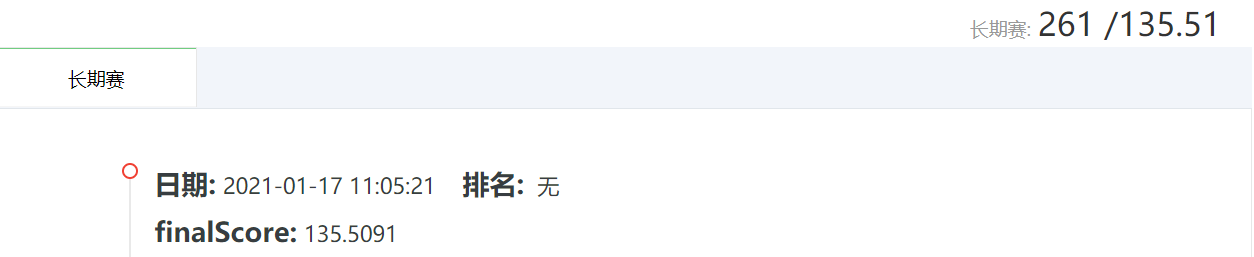